## **Lab 6**

---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch.nn as nn
import torch.optim as optim

### **Part 1: Data Preparation**

In [36]:
not_loaded = False

#### **Data Loading**

In [37]:
if not_loaded:
    file_path = "D:/Acads/6th Semester/DL/Lab 6/southeast.csv"
    df = pd.read_csv(file_path)

    # Rename columns
    abbreviation = ['date','hour','prcp', 'stp', 'smax', 'smin','gbrd','temp','dewp','tmax','tmin','dmax','dmin',
                    'hmax','hmin','hmdy','wdct', 'gust', 'wdsp', 'regi','prov','wsnm','inme','lat','lon','elvt']

    # Drop 'index' column if it exists
    df.drop(columns=['index'], errors='ignore', inplace=True)

    df.columns = abbreviation

    # Combine date and hour columns into a datetime column
    df['date_time'] = pd.to_datetime(df['date'] + ' ' + df['hour'])
    df.set_index('date_time', inplace=True)

    # Drop unnecessary columns
    df.drop(['date', 'hour', 'regi', 'prov', 'wsnm', 'lat', 'lon', 'elvt'], axis=1, inplace=True)

In [38]:
if not_loaded:
    # Get the first station's data
    station_codes = df['inme'].unique()
    first_station = station_codes[0]  # Select first station
    df_first_station = df[df['inme'] == first_station].copy()

    # Keep only the required columns
    df_first_station = df_first_station[['temp', 'hmdy', 'wdsp']]

    # Save the new CSV file
    output_file_path = "D:/Acads/6th Semester/DL/Lab 6/first_station_data.csv"
    df_first_station.to_csv(output_file_path)

In [39]:
if not not_loaded:
    df_models = pd.read_csv("D:/Acads/6th Semester/DL/Lab 6/first_station_data.csv", parse_dates=['date_time'], index_col='date_time')

In [40]:
# Function to clean missing values
def clean_na(df, na_value=-9999):
    df.replace(to_replace=na_value, value=np.NaN, inplace=True)
    df.fillna(method='ffill', inplace=True)
    return df

if not_loaded:
    df_models = clean_na(df_first_station)
else:
    df_models = clean_na(df_models)

C:\Users\91883\AppData\Local\Temp\ipykernel_21160\3486220486.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


#### **EDA**

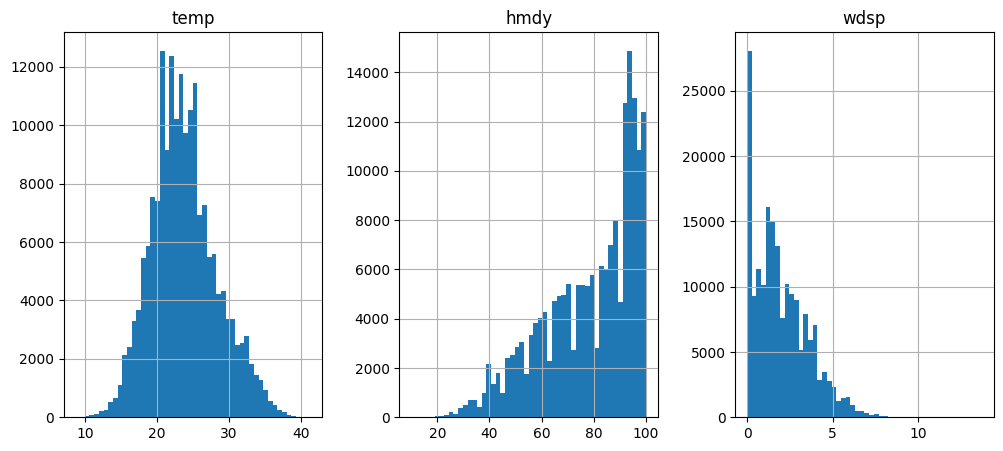

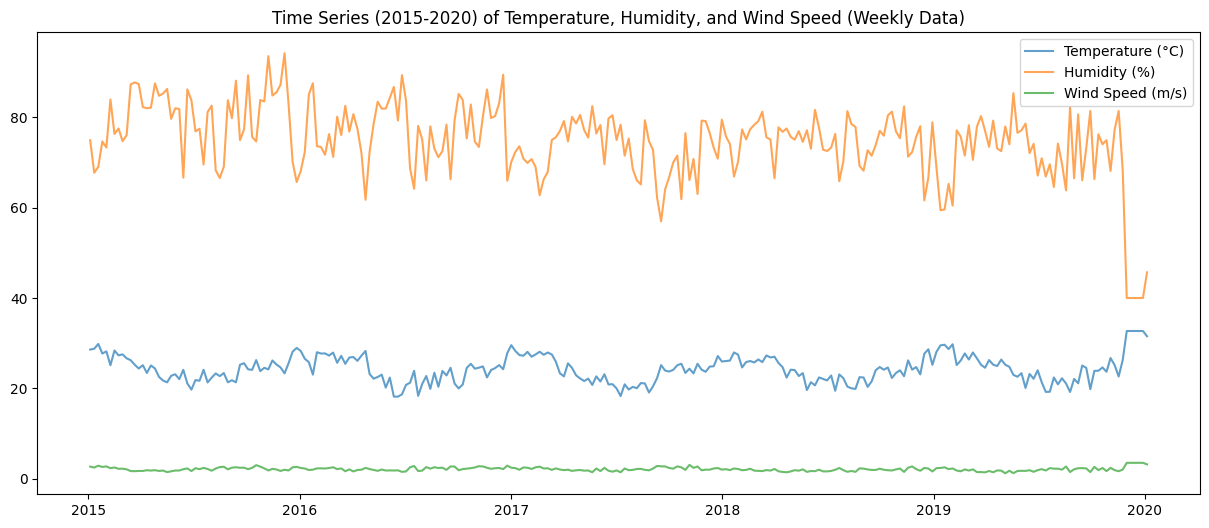

<Figure size 1200x500 with 0 Axes>

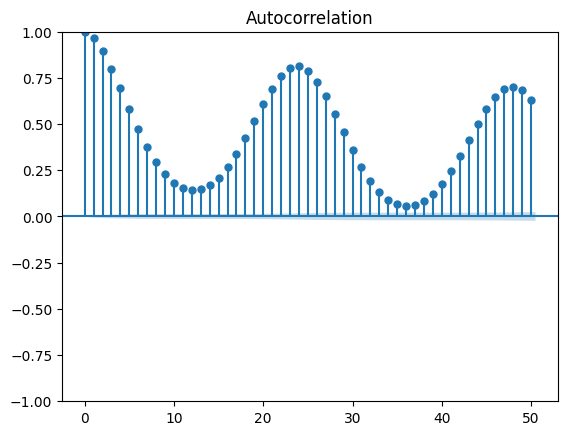

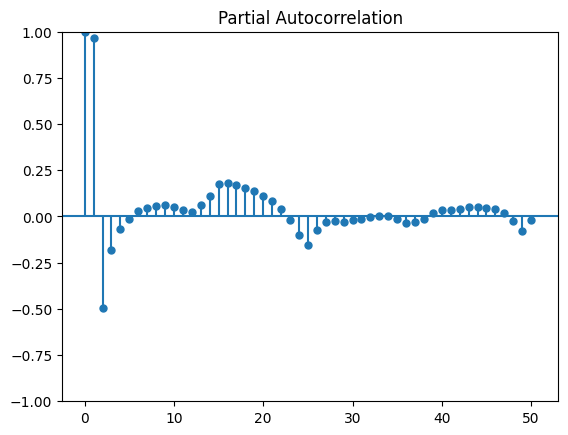

In [11]:
df_models.sort_index(inplace=True)

# Distribution of Key Features
selected_columns = ['temp', 'hmdy', 'wdsp']

# Distribution of Key Features
df_models[selected_columns].hist(bins=50, figsize=(12, 5), layout=(1, 3))
plt.show()

# Time Series Plots
# Select data from the last 5 years and resample weekly
start_date = "2015-01-01"
end_date = "2020-01-01"
df_filtered = df_models.loc[start_date:end_date].resample('W').mean()  # Weekly average

plt.figure(figsize=(15, 6))

plt.plot(df_filtered.index, df_filtered['temp'], label="Temperature (°C)", alpha=0.7)
plt.plot(df_filtered.index, df_filtered['hmdy'], label="Humidity (%)", alpha=0.7)
plt.plot(df_filtered.index, df_filtered['wdsp'], label="Wind Speed (m/s)", alpha=0.7)

plt.legend()
plt.title("Time Series (2015-2020) of Temperature, Humidity, and Wind Speed (Weekly Data)")
plt.show()

# ACF and PACF for Temperature
plt.figure(figsize=(12, 5))

# Select temperature column
temp_col = 'temp'

plot_acf(df_models[temp_col].dropna(), lags=50)
plot_pacf(df_models[temp_col].dropna(), lags=50)
plt.show()

##### **Pre-processing**

In [41]:
def preprocess_data(df_models, seq_length=24, batch_size=64, val_split=0.2, test_split=0.1):
    """Prepares data for training, validation, and test sets."""

    # Select relevant columns
    selected_columns = ['temp', 'hmdy', 'wdsp']
    data = df_models[selected_columns].dropna()  # Remove NaNs

    # Normalize Data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Convert to PyTorch Tensor
    data_tensor = torch.tensor(data_scaled, dtype=torch.float32)

    def create_sequences(data, seq_length):
        """Generates sequences and labels for time-series data."""
        sequences, labels = [], []

        for i in range(len(data) - seq_length):
            sequences.append(data[i:i + seq_length])
            labels.append(data[i + seq_length - 1])  # Fix label index

        return torch.stack(sequences), torch.stack(labels)  # Use torch.stack() to avoid shape issues

    X, y = create_sequences(data_tensor, seq_length)
    dataset = TensorDataset(X, y)

    # Compute split sizes
    test_size = int(len(dataset) * test_split)
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size - test_size

    # Split into train, validation, and test sets
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, scaler, X

### **Part 2: VAE**

In [42]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=8):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        self.mu_layer = nn.Linear(64, latent_dim)  # Mean of latent space
        self.logvar_layer = nn.Linear(64, latent_dim)  # Log variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
        )

    def reparameterize(self, mu, logvar):
        """Reparameterization trick to sample from N(mu, sigma^2)"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        mu, logvar = self.mu_layer(encoded), self.logvar_layer(encoded)

        # Sample from latent space
        z = self.reparameterize(mu, logvar)

        # Decode
        reconstructed = self.decoder(z)

        return reconstructed, mu, logvar

In [43]:
def train_vae(vae, train_loader, val_loader, epochs=50, patience=5, lr=0.001):
    """Trains the VAE with validation and early stopping."""

    optimizer = optim.Adam(vae.parameters(), lr=lr)

    def loss_function(recon_x, x, mu, logvar):
        """VAE loss: Reconstruction loss + KL divergence."""
        recon_loss = nn.MSELoss()(recon_x, x)
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_loss

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    early_stop_count = 0

    for epoch in range(epochs):
        vae.train()
        train_loss = 0.0

        for batch in train_loader:
            inputs, _ = batch
            optimizer.zero_grad()
            recon, mu, logvar = vae(inputs)
            loss = loss_function(recon, inputs, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation Step
        vae.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs, _ = batch
                recon, mu, logvar = vae(inputs)
                loss = loss_function(recon, inputs, mu, logvar)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_count = 0
        else:
            early_stop_count += 1
            if early_stop_count >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Plot Training & Validation Loss
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [44]:
def detect_anomalies(vae, X, threshold_percentile=95):
    """Detects anomalies using reconstruction error."""

    vae.eval()
    reconstructions = []

    for i in range(len(X)):
        x_input = X[i].unsqueeze(0)
        recon, _, _ = vae(x_input)
        loss = torch.mean((recon - x_input) ** 2).item()
        reconstructions.append(loss)

    reconstructions = np.array(reconstructions)
    threshold = np.percentile(reconstructions, threshold_percentile)
    anomalies = reconstructions > threshold

    return anomalies, reconstructions, threshold

In [45]:
def visualize_latent_space(vae, X, method='PCA'):
    """Visualizes the latent space using PCA or t-SNE."""
    vae.eval()
    latent_vectors = []

    for i in range(len(X)):
        x_input = X[i].unsqueeze(0)
        _, mu, _ = vae(x_input)
        latent_vectors.append(mu.detach().numpy())

    latent_vectors = np.array(latent_vectors).squeeze()

    if method == 'PCA':
        pca = PCA(n_components=2)
        latent_2d = pca.fit_transform(latent_vectors)
    elif method == 't-SNE':
        tsne = TSNE(n_components=2)
        latent_2d = tsne.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 6))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c='blue', alpha=0.5)
    plt.title(f"Latent Space Visualization using {method}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

In [57]:
def analyze_latent_space(model, data_loader, device):
    """Analyze the latent space representations using PCA."""
    model.to(device)
    model.eval()
    latent_vectors = []

    with torch.no_grad():
        for batch in data_loader:
            if isinstance(batch, (list, tuple)):
                batch = batch[0]  # Extract first tensor if wrapped in list/tuple

            batch = batch.to(device)

            # Handle multiple outputs from the model
            model_output = model(batch)  # Assuming future_steps=1 for latent representation

            if isinstance(model_output, tuple) or isinstance(model_output, list):
                latent = model_output[1]  # Assume the second output is the latent representation
            else:
                raise ValueError("Unexpected model output format. Ensure it returns (recon, latent, *other)")

            latent_vectors.append(latent.cpu().numpy())  # Convert to NumPy

    # Convert list to NumPy array
    latent_vectors = np.concatenate(latent_vectors, axis=0)

    print("Latent vector shape before PCA:", latent_vectors.shape)

    # Reduce seq_len dimension by averaging (if applicable)
    if len(latent_vectors.shape) == 3:  
        latent_vectors_mean = latent_vectors.mean(axis=1)  # (batch, latent_dim)
    else:
        latent_vectors_mean = latent_vectors  # Already in correct shape

    # Apply PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_vectors_mean)

    # Plot the PCA projection
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.7, c=np.arange(len(latent_2d)), cmap='viridis')
    plt.colorbar(scatter, label="Sample Index")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("2D PCA Projection of Latent Space")
    plt.grid(True)
    plt.show()

    return latent_vectors_mean, latent_2d

In [47]:
def generate_synthetic_data(vae, scaler, num_samples=10):
    """Generates new synthetic weather data by sampling from the latent space."""
    vae.eval()
    synthetic_data = []

    for _ in range(num_samples):
        z = torch.randn(1, vae.mu_layer.out_features)
        synthetic_sample = vae.decoder(z).detach().numpy()
        synthetic_data.append(synthetic_sample)

    synthetic_data = np.array(synthetic_data).squeeze()
    synthetic_data = scaler.inverse_transform(synthetic_data)

    return synthetic_data

In [48]:
train_loader, val_loader, test_loader, scaler, X = preprocess_data(df_models, seq_length=168)

In [50]:
input_dim = X.shape[2]  # Number of weather features
latent_dim = 8  # Justification: Small enough to compress info, but captures variance
vae = VAE(input_dim, latent_dim)

Epoch 1: Train Loss = 0.4189, Val Loss = 0.4051
Epoch 2: Train Loss = 0.4041, Val Loss = 0.4048
Epoch 3: Train Loss = 0.4034, Val Loss = 0.4036
Epoch 4: Train Loss = 0.4031, Val Loss = 0.4031
Epoch 5: Train Loss = 0.4031, Val Loss = 0.4031
Epoch 6: Train Loss = 0.4030, Val Loss = 0.4035
Epoch 7: Train Loss = 0.4029, Val Loss = 0.4037
Epoch 8: Train Loss = 0.4029, Val Loss = 0.4033
Epoch 9: Train Loss = 0.4028, Val Loss = 0.4031
Early stopping at epoch 9


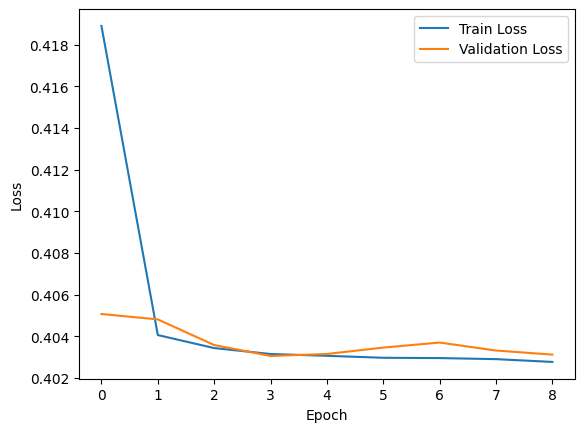

In [15]:
train_vae(vae, train_loader, val_loader)

In [16]:
# Save the trained model
model_path = "D:/Acads/6th Semester/DL/Lab 6/vae_model.pth"
torch.save(vae.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to D:/Acads/6th Semester/DL/Lab 6/vae_model.pth


In [17]:
anomalies, reconstructions, threshold = detect_anomalies(vae, X)

In [18]:
index_subset = df_models.index[24:24+len(reconstructions)]
print(f"Index subset length: {len(index_subset)}")
print(f"Reconstruction error length: {len(reconstructions)}")
print(f"Anomalies length: {len(anomalies)}")

Index subset length: 183756
Reconstruction error length: 183756
Anomalies length: 183756


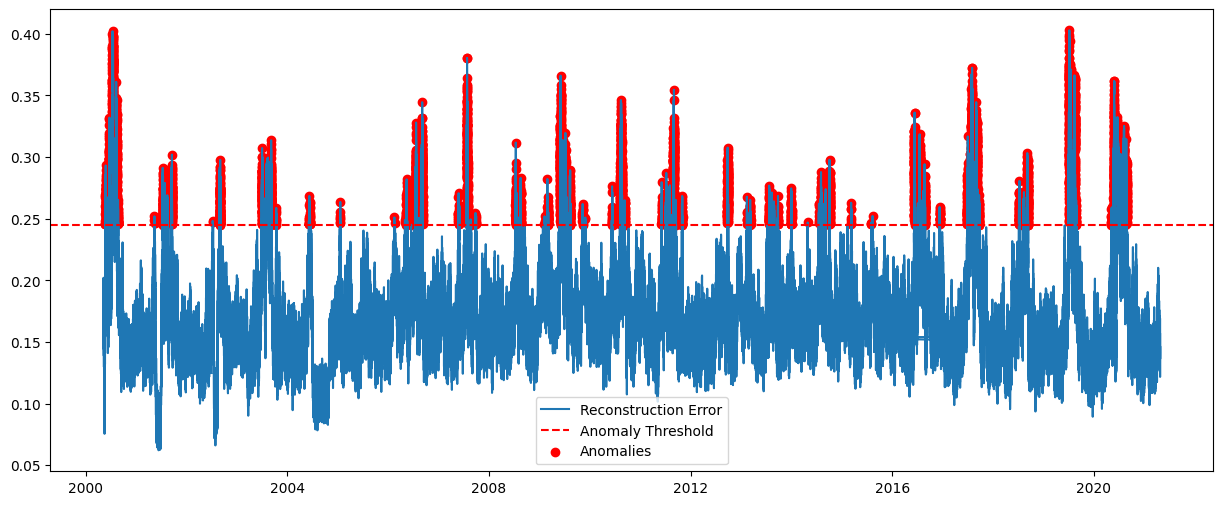

In [19]:
plt.figure(figsize=(15, 6))
plt.plot(df_models.index[24:24+len(reconstructions)], reconstructions, label="Reconstruction Error")
plt.axhline(threshold, color="r", linestyle="--", label="Anomaly Threshold")
# Fix indexing by ensuring lengths match exactly
plt.scatter(df_models.index[24:24+len(reconstructions)][anomalies],
            reconstructions[anomalies],
            color="red", label="Anomalies")

plt.legend()
plt.show()

In [58]:
# Load the model state dictionary
model_path = "D:/Acads/6th Semester/DL/Lab 6/vae_model.pth"
vae.load_state_dict(torch.load(model_path))

C:\Users\91883\AppData\Local\Temp\ipykernel_21160\3170753371.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


<All keys matched successfully>

Step 7: Analyzing latent space representations...
Latent vector shape before PCA: (18375, 168, 8)


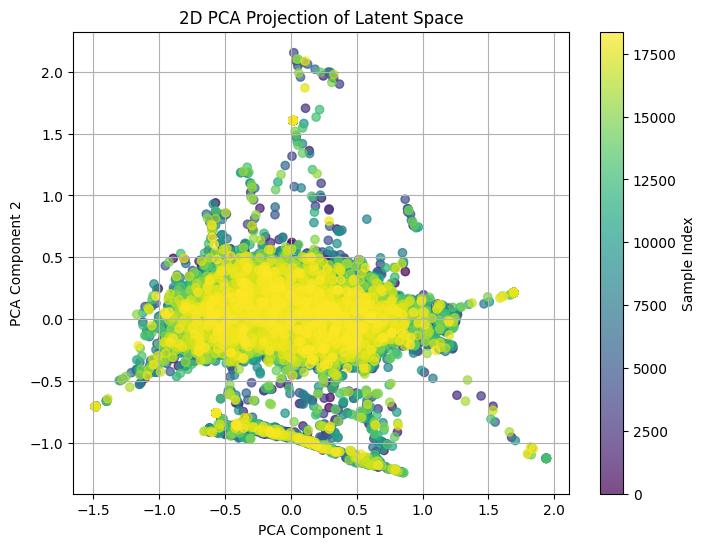

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (mu_layer): Linear(in_features=64, out_features=8, bias=True)
  (logvar_layer): Linear(in_features=64, out_features=8, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [61]:
print("Step 7: Analyzing latent space representations...")
latent_vectors, original_samples = analyze_latent_space(
    vae,
    test_loader,
   device='cuda' if torch.cuda.is_available() else 'cpu'
)
vae.to('cpu')

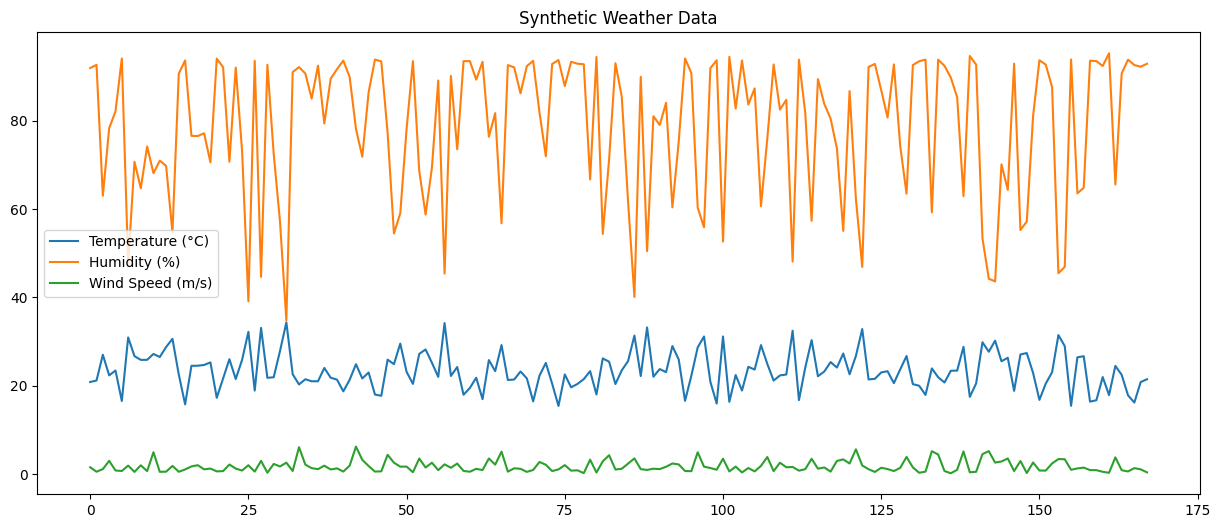

In [67]:
# Generate new synthetic weather data
synthetic_data = generate_synthetic_data(vae, scaler, num_samples=168)

# Convert synthetic data to DataFrame for visualization
synthetic_df = pd.DataFrame(synthetic_data, columns=['temp', 'hmdy', 'wdsp'])

# Visualize synthetic data
plt.figure(figsize=(15, 6))
plt.plot(synthetic_df['temp'], label="Temperature (°C)")
plt.plot(synthetic_df['hmdy'], label="Humidity (%)")
plt.plot(synthetic_df['wdsp'], label="Wind Speed (m/s)")
plt.legend()
plt.title("Synthetic Weather Data")
plt.show()

### **Part 3: GRU**

In [2]:
class WeatherDataset(Dataset):
    def __init__(self, data, seq_length, pred_length):
        self.data = data
        self.seq_length = seq_length
        self.pred_length = pred_length

    def __len__(self):
        return len(self.data) - self.seq_length - self.pred_length + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]
        y = self.data[idx + self.seq_length:idx + self.seq_length + self.pred_length]
        return x, y

def preprocess_data_2(df, seq_length=24, pred_length=12, batch_size=64, val_split=0.2, test_split=0.1):
    selected_columns = ['temp', 'hmdy', 'wdsp']
    data = df[selected_columns].dropna()

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    dataset = WeatherDataset(torch.tensor(data_scaled, dtype=torch.float32), seq_length, pred_length)

    test_size = int(len(dataset) * test_split)
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size - test_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, scaler

In [3]:
class GRUForecastingModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(GRUForecastingModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, future_steps):
        out, _ = self.gru(x)
        outputs = []
        last_output = out[:, -1, :].unsqueeze(1)
        for _ in range(future_steps):
            out_step = self.fc(last_output)
            outputs.append(out_step)
            last_output, _ = self.gru(out_step)
        return torch.cat(outputs, dim=1)

In [ ]:
def train_gru(model, train_loader, val_loader, epochs=50, lr=0.001, teacher_forcing_ratio=0.5, device='cuda', patience=5):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            # Teacher forcing
            if torch.rand(1).item() < teacher_forcing_ratio:
                output = model(x, y.size(1))
            else:
                output = model(x, y.size(1))

            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output = model(x, y.size(1))
                loss = criterion(output, y)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

        # Decay teacher forcing ratio
        teacher_forcing_ratio *= 0.99

    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))

In [30]:
def evaluate_gru(model, test_loader, scaler, device='cuda'):
    model.to(device)
    model.eval()
    predictions, actuals = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            output = model(x, y.size(1))
            predictions.append(output.cpu().numpy())
            actuals.append(y.cpu().numpy())

    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)

    # Reshape to 2D for inverse transform
    predictions_reshaped = predictions.reshape(-1, predictions.shape[-1])
    actuals_reshaped = actuals.reshape(-1, actuals.shape[-1])

    predictions_inverse = scaler.inverse_transform(predictions_reshaped)
    actuals_inverse = scaler.inverse_transform(actuals_reshaped)

    # Reshape back to original shape
    predictions = predictions_inverse.reshape(predictions.shape)
    actuals = actuals_inverse.reshape(actuals.shape)

    # Reshape to 2D for metric calculation
    predictions_flat = predictions.reshape(-1, predictions.shape[-1])
    actuals_flat = actuals.reshape(-1, actuals.shape[-1])

    mse = mean_squared_error(actuals_flat, predictions_flat)
    mae = mean_absolute_error(actuals_flat, predictions_flat)
    rmse = np.sqrt(mse)

    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # Create a DataFrame for plotting
    test_indices = df.index[-len(actuals_flat):]
    df_results = pd.DataFrame(data=actuals_flat[:len(test_indices)], index=test_indices, columns=['temp_actual', 'hmdy_actual', 'wdsp_actual'])
    df_results[['temp_pred', 'hmdy_pred', 'wdsp_pred']] = predictions_flat[:len(test_indices)]

    # Select a specific date range for plotting (e.g., last year)
    start_date = df_results.index[-1] - pd.DateOffset(years=1)
    df_results = df_results.loc[start_date:]

    # Resample to weekly average
    df_results_resampled = df_results.resample('W').mean()

    plt.figure(figsize=(15, 6))
    plt.plot(df_results_resampled.index, df_results_resampled['temp_actual'], label="Actual Temperature (°C)", alpha=0.7)
    plt.plot(df_results_resampled.index, df_results_resampled['temp_pred'], label="Predicted Temperature (°C)", alpha=0.7)
    plt.plot(df_results_resampled.index, df_results_resampled['hmdy_actual'], label="Actual Humidity (%)", alpha=0.7)
    plt.plot(df_results_resampled.index, df_results_resampled['hmdy_pred'], label="Predicted Humidity (%)", alpha=0.7)
    plt.plot(df_results_resampled.index, df_results_resampled['wdsp_actual'], label="Actual Wind Speed (m/s)", alpha=0.7)
    plt.plot(df_results_resampled.index, df_results_resampled['wdsp_pred'], label="Predicted Wind Speed (m/s)", alpha=0.7)
    plt.legend()
    plt.title("Time Series of Actual vs Predicted Weather Metrics (Weekly Data)")
    plt.show()

In [69]:
# Load and preprocess data
file_path = "D:/Acads/6th Semester/DL/Lab 6/first_station_data.csv"
df = pd.read_csv(file_path, parse_dates=['date_time'], index_col='date_time')
df = df.replace(-9999, np.nan).fillna(method='ffill')
df.sort_index(inplace=True)

C:\Users\91883\AppData\Local\Temp\ipykernel_21160\2973307372.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.replace(-9999, np.nan).fillna(method='ffill')


In [70]:
seq_length = 24
pred_length = 12
batch_size = 64

In [71]:
train_loader, val_loader, test_loader, scaler = preprocess_data_2(df, seq_length, pred_length, batch_size)

In [72]:
input_dim = len(['temp', 'hmdy', 'wdsp'])
hidden_dim = 64
output_dim = len(['temp', 'hmdy', 'wdsp'])
num_layers = 1

model = GRUForecastingModel(input_dim, hidden_dim, output_dim, num_layers)

In [73]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Epoch 1: Train Loss = 0.6022, Val Loss = 0.5050
Epoch 2: Train Loss = 0.4638, Val Loss = 0.4437
Epoch 3: Train Loss = 0.4431, Val Loss = 0.4320
Epoch 4: Train Loss = 0.4346, Val Loss = 0.4250
Epoch 5: Train Loss = 0.4284, Val Loss = 0.4270
Epoch 6: Train Loss = 0.4246, Val Loss = 0.4236
Epoch 7: Train Loss = 0.4214, Val Loss = 0.4243
Epoch 8: Train Loss = 0.4172, Val Loss = 0.4143
Epoch 9: Train Loss = 0.4141, Val Loss = 0.4142
Epoch 10: Train Loss = 0.4124, Val Loss = 0.4116
Epoch 11: Train Loss = 0.4106, Val Loss = 0.4091
Epoch 12: Train Loss = 0.4084, Val Loss = 0.4032
Epoch 13: Train Loss = 0.4058, Val Loss = 0.4030
Epoch 14: Train Loss = 0.4047, Val Loss = 0.4026
Epoch 15: Train Loss = 0.4020, Val Loss = 0.4019
Epoch 16: Train Loss = 0.4004, Val Loss = 0.4140
Epoch 17: Train Loss = 0.3986, Val Loss = 0.3980
Epoch 18: Train Loss = 0.3962, Val Loss = 0.3992
Epoch 19: Train Loss = 0.3947, Val Loss = 0.3970
Epoch 20: Train Loss = 0.3921, Val Loss = 0.3900
Epoch 21: Train Loss = 0.3905

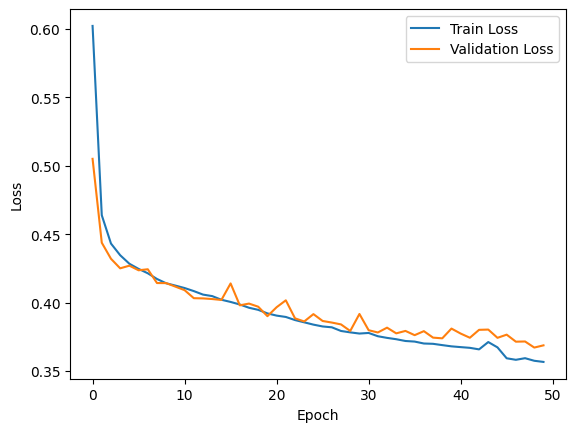

C:\Users\91883\AppData\Local\Temp\ipykernel_21160\425962131.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [74]:
train_gru(model, train_loader, val_loader, epochs=50, lr=0.001, device=device)

In [75]:
# Save the trained model
model_path = "D:/Acads/6th Semester/DL/Lab 6/gru_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to D:/Acads/6th Semester/DL/Lab 6/gru_model.pth


In [9]:
# Load the model state dictionary
model_path = "D:/Acads/6th Semester/DL/Lab 6/gru_model.pth"
model.load_state_dict(torch.load(model_path))

C:\Users\91883\AppData\Local\Temp\ipykernel_21160\4122975844.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

MSE: 33.0129, MAE: 3.2312, RMSE: 5.7457


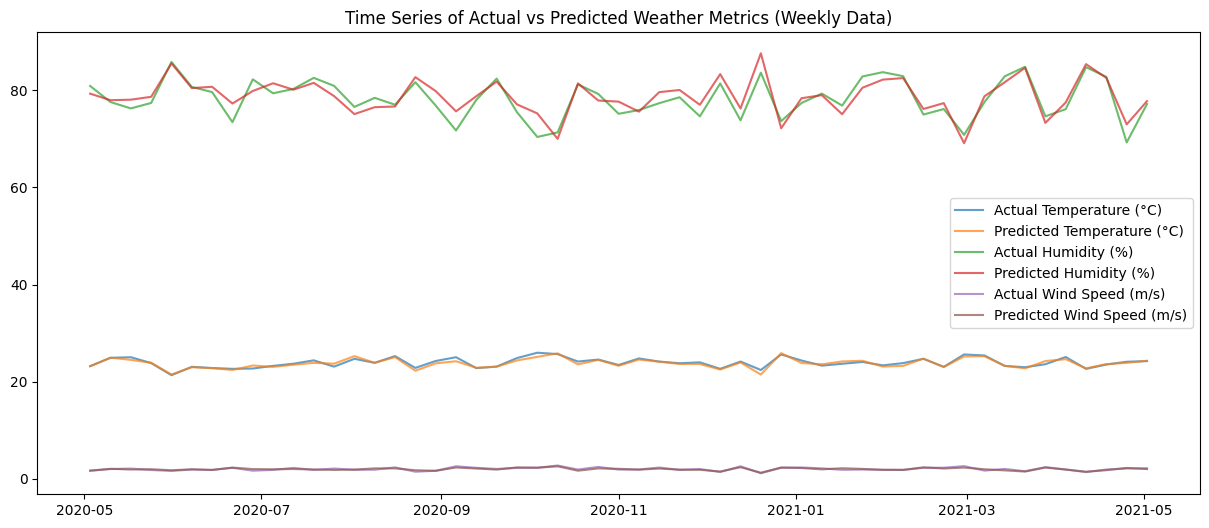

In [76]:
evaluate_gru(model, test_loader, scaler, device=device)

In [77]:
def evaluate_gru_horizons(model, test_loader, scaler, df, seq_length, pred_length, device='cuda'):
    model.to(device)
    model.eval()
    horizons = list(range(1, pred_length + 1))
    mse_list, mae_list, rmse_list = [], [], []

    for horizon in horizons:
        predictions, actuals = [], []

        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                output = model(x, horizon)
                predictions.append(output.cpu().numpy())
                actuals.append(y[:, :horizon].cpu().numpy())

        predictions = np.concatenate(predictions)
        actuals = np.concatenate(actuals)

        # Reshape to 2D for inverse transform
        predictions_reshaped = predictions.reshape(-1, predictions.shape[-1])
        actuals_reshaped = actuals.reshape(-1, actuals.shape[-1])

        predictions_inverse = scaler.inverse_transform(predictions_reshaped)
        actuals_inverse = scaler.inverse_transform(actuals_reshaped)

        # Reshape back to original shape
        predictions = predictions_inverse.reshape(predictions.shape)
        actuals = actuals_inverse.reshape(actuals.shape)

        # Reshape to 2D for metric calculation
        predictions_flat = predictions.reshape(-1, predictions.shape[-1])
        actuals_flat = actuals.reshape(-1, actuals.shape[-1])

        mse = mean_squared_error(actuals_flat, predictions_flat)
        mae = mean_absolute_error(actuals_flat, predictions_flat)
        rmse = np.sqrt(mse)

        mse_list.append(mse)
        mae_list.append(mae)
        rmse_list.append(rmse)

    # Plot the metrics for different prediction horizons
    plt.figure(figsize=(15, 6))
    plt.plot(horizons, mse_list, label="MSE")
    plt.plot(horizons, mae_list, label="MAE")
    plt.plot(horizons, rmse_list, label="RMSE")
    plt.xlabel("Prediction Horizon (hours)")
    plt.ylabel("Error")
    plt.legend()
    plt.title("Error Metrics for Different Prediction Horizons")
    plt.show()

    return mse_list, mae_list, rmse_list

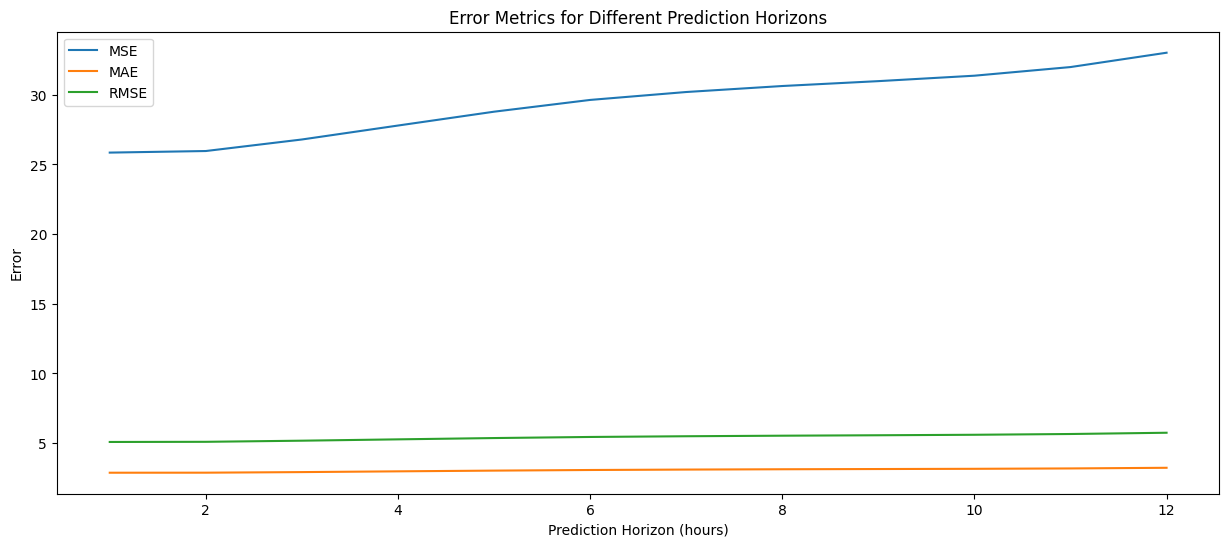

In [78]:
mse_list, mae_list, rmse_list = evaluate_gru_horizons(model, test_loader, scaler, df, seq_length, pred_length, device=device)

In [83]:
class LSTMForecastingModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMForecastingModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, future_steps):
        out, _ = self.lstm(x)
        outputs = []
        last_output = out[:, -1, :].unsqueeze(1)
        for _ in range(future_steps):
            out_step = self.fc(last_output)
            outputs.append(out_step)
            last_output, _ = self.lstm(out_step)
        return torch.cat(outputs, dim=1)

class RNNForecastingModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(RNNForecastingModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, future_steps):
        out, _ = self.rnn(x)
        outputs = []
        last_output = out[:, -1, :].unsqueeze(1)
        for _ in range(future_steps):
            out_step = self.fc(last_output)
            outputs.append(out_step)
            last_output, _ = self.rnn(out_step)
        return torch.cat(outputs, dim=1)

In [91]:
def train_and_evaluate(model_class, input_dim, hidden_dim, output_dim, num_layers, seq_length, pred_length, df, device):
    train_loader, val_loader, test_loader, scaler = preprocess_data_2(df, seq_length, pred_length, batch_size=64)
    model = model_class(input_dim, hidden_dim, output_dim, num_layers)
    train_gru(model, train_loader, val_loader, epochs=10, lr=0.001, device=device, patience=3)
    mse_list, mae_list, rmse_list = evaluate_gru_horizons(model, test_loader, scaler, df, seq_length, pred_length, device=device)
    return mse_list, mae_list, rmse_list

Evaluating models with sequence length: 24
GRU Model:
Epoch 1: Train Loss = 0.5874, Val Loss = 0.4730
Epoch 2: Train Loss = 0.4641, Val Loss = 0.4429
Epoch 3: Train Loss = 0.4479, Val Loss = 0.4450
Epoch 4: Train Loss = 0.4377, Val Loss = 0.4260
Epoch 5: Train Loss = 0.4323, Val Loss = 0.4201
Epoch 6: Train Loss = 0.4280, Val Loss = 0.4196
Epoch 7: Train Loss = 0.4238, Val Loss = 0.4286
Epoch 8: Train Loss = 0.4206, Val Loss = 0.4154
Epoch 9: Train Loss = 0.4181, Val Loss = 0.4175
Epoch 10: Train Loss = 0.4155, Val Loss = 0.4095


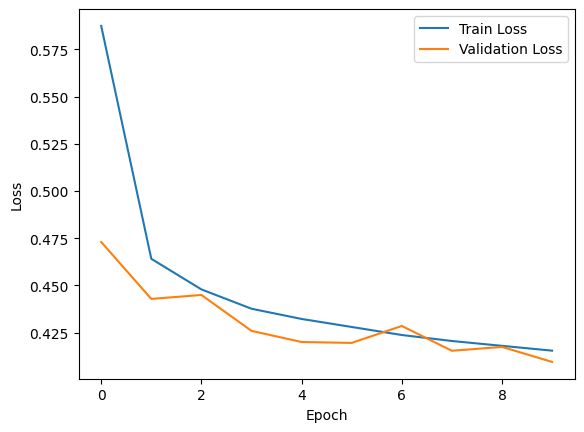

C:\Users\91883\AppData\Local\Temp\ipykernel_21160\777473553.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


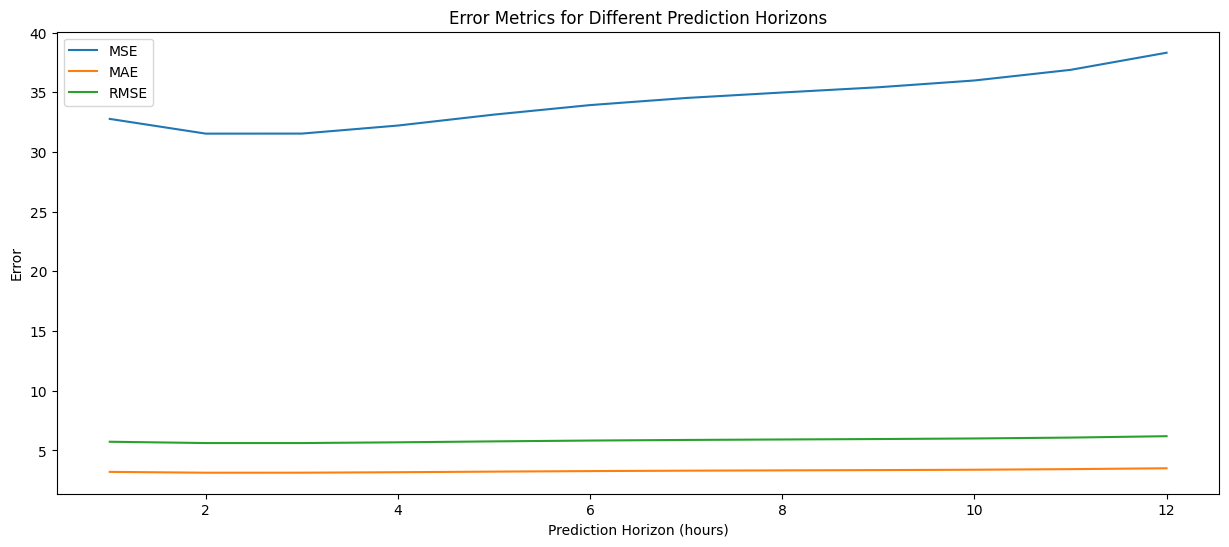

LSTM Model:
Epoch 1: Train Loss = 0.6089, Val Loss = 0.5037
Epoch 2: Train Loss = 0.4720, Val Loss = 0.4487
Epoch 3: Train Loss = 0.4383, Val Loss = 0.4360
Epoch 4: Train Loss = 0.4306, Val Loss = 0.4228
Epoch 5: Train Loss = 0.4250, Val Loss = 0.4223
Epoch 6: Train Loss = 0.4211, Val Loss = 0.4166
Epoch 7: Train Loss = 0.4165, Val Loss = 0.4193
Epoch 8: Train Loss = 0.4138, Val Loss = 0.4213
Epoch 9: Train Loss = 0.4109, Val Loss = 0.4055
Epoch 10: Train Loss = 0.4074, Val Loss = 0.4025


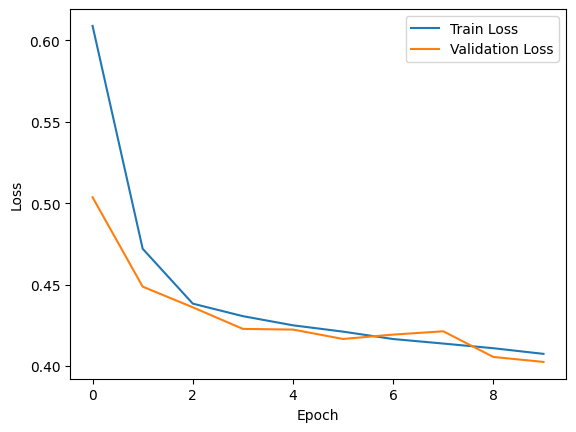

C:\Users\91883\AppData\Local\Temp\ipykernel_21160\777473553.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


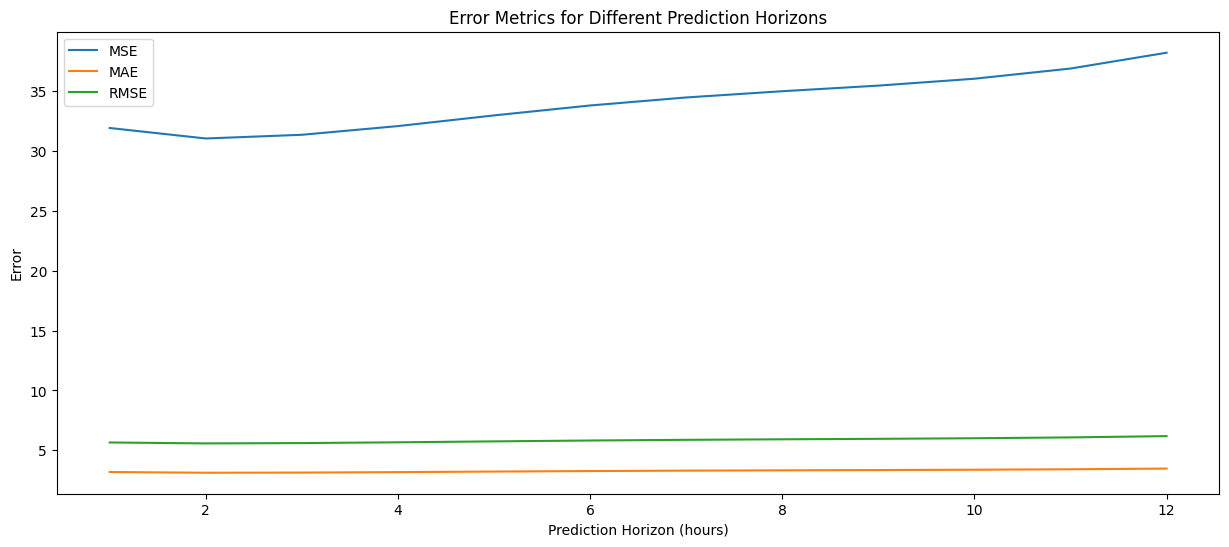

RNN Model:
Epoch 1: Train Loss = 0.6174, Val Loss = 0.5110
Epoch 2: Train Loss = 0.4981, Val Loss = 0.4836
Epoch 3: Train Loss = 0.4807, Val Loss = 0.4672
Epoch 4: Train Loss = 0.4730, Val Loss = 0.4650
Epoch 5: Train Loss = 0.4667, Val Loss = 0.4660
Epoch 6: Train Loss = 0.4631, Val Loss = 0.4550
Epoch 7: Train Loss = 0.4598, Val Loss = 0.4889
Epoch 8: Train Loss = 0.4562, Val Loss = 0.4504
Epoch 9: Train Loss = 0.4540, Val Loss = 0.4542
Epoch 10: Train Loss = 0.4520, Val Loss = 0.4697


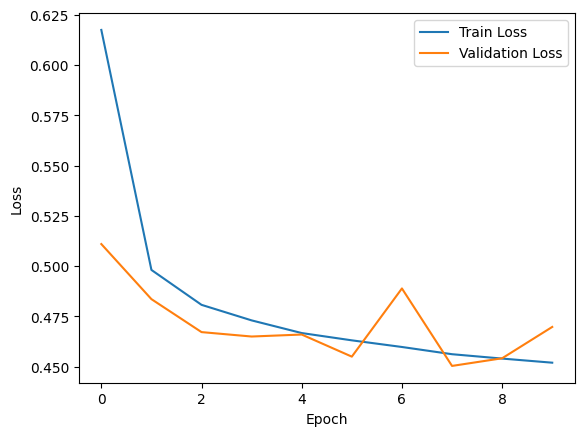

C:\Users\91883\AppData\Local\Temp\ipykernel_21160\777473553.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


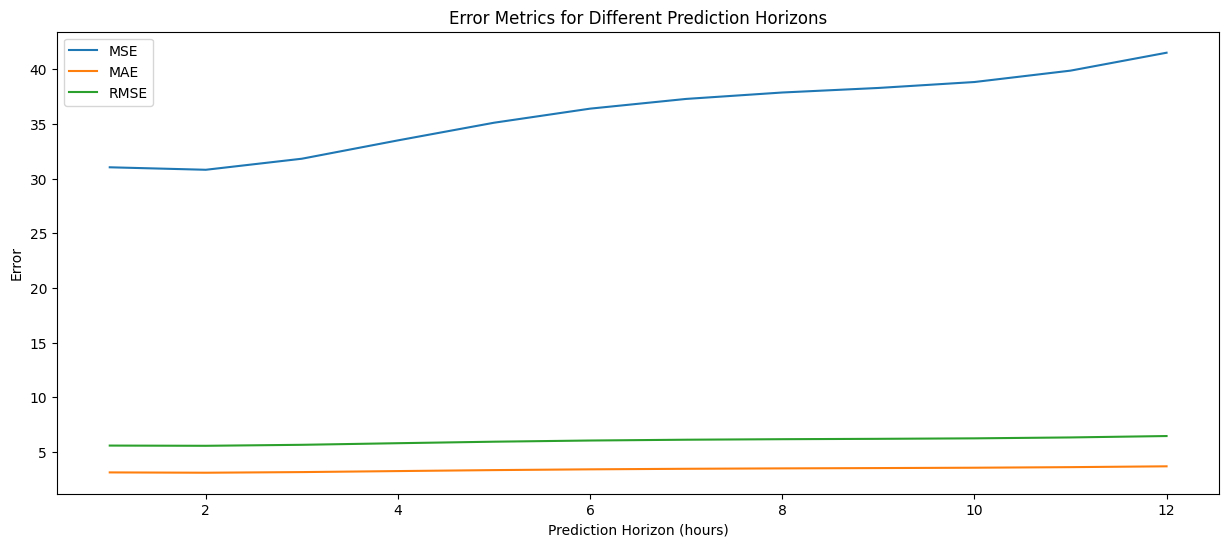

([31.031334,
  30.804245,
  31.81592,
  33.493435,
  35.108807,
  36.39728,
  37.28703,
  37.8737,
  38.28963,
  38.832832,
  39.87411,
  41.51353],
 [3.114971,
  3.0865366,
  3.144662,
  3.2370923,
  3.326374,
  3.3967464,
  3.4467356,
  3.483304,
  3.5116684,
  3.5440295,
  3.596392,
  3.6722338],
 [5.5705776,
  5.550157,
  5.64056,
  5.787351,
  5.9252687,
  6.0330157,
  6.106311,
  6.154161,
  6.1878614,
  6.2315993,
  6.314595,
  6.4430995])

In [92]:
# Define model parameters
input_dim = len(['temp', 'hmdy', 'wdsp'])
hidden_dim = 64
output_dim = len(['temp', 'hmdy', 'wdsp'])
num_layers = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Evaluate GRU, LSTM, and RNN models
print(f"Evaluating models with sequence length: {seq_length}")
print("GRU Model:")
train_and_evaluate(GRUForecastingModel, input_dim, hidden_dim, output_dim, num_layers, seq_length, pred_length, df, device)
print("LSTM Model:")
train_and_evaluate(LSTMForecastingModel, input_dim, hidden_dim, output_dim, num_layers, seq_length, pred_length, df, device)
print("RNN Model:")
train_and_evaluate(RNNForecastingModel, input_dim, hidden_dim, output_dim, num_layers, seq_length, pred_length, df, device)

### **Part 4: Model Integration and Analysis**

In [79]:
# Load the VAE model
vae_model_path = "D:/Acads/6th Semester/DL/Lab 6/vae_model.pth"
vae = VAE(input_dim, latent_dim)
vae.load_state_dict(torch.load(vae_model_path))
vae.eval()

# Detect anomalies using the VAE
anomalies, reconstructions, threshold = detect_anomalies(vae, X)

C:\Users\91883\AppData\Local\Temp\ipykernel_21160\2460561045.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(vae_model_path))


In [89]:
def evaluate_gru_on_normal_vs_anomalous(model, test_loader, scaler, anomalies, device='cuda'):
    model.to(device)
    model.eval()
    normal_predictions, normal_actuals = [], []
    anomalous_predictions, anomalous_actuals = [], []

    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            output = model(x, y.size(1))

            if anomalies[i]:
                anomalous_predictions.append(output.cpu().numpy())
                anomalous_actuals.append(y.cpu().numpy())
            else:
                normal_predictions.append(output.cpu().numpy())
                normal_actuals.append(y.cpu().numpy())

    def calculate_metrics(predictions, actuals):
        if len(predictions) == 0 or len(actuals) == 0:
            return float('nan'), float('nan'), float('nan')

        predictions = np.concatenate(predictions)
        actuals = np.concatenate(actuals)

        # Reshape to 2D for inverse transform
        predictions_reshaped = predictions.reshape(-1, predictions.shape[-1])
        actuals_reshaped = actuals.reshape(-1, actuals.shape[-1])

        predictions_inverse = scaler.inverse_transform(predictions_reshaped)
        actuals_inverse = scaler.inverse_transform(actuals_reshaped)

        # Reshape back to original shape
        predictions = predictions_inverse.reshape(predictions.shape)
        actuals = actuals_inverse.reshape(actuals.shape)

        # Reshape to 2D for metric calculation
        predictions_flat = predictions.reshape(-1, predictions.shape[-1])
        actuals_flat = actuals.reshape(-1, actuals.shape[-1])

        mse = mean_squared_error(actuals_flat, predictions_flat)
        mae = mean_absolute_error(actuals_flat, predictions_flat)
        rmse = np.sqrt(mse)

        return mse, mae, rmse

    normal_mse, normal_mae, normal_rmse = calculate_metrics(normal_predictions, normal_actuals)
    anomalous_mse, anomalous_mae, anomalous_rmse = calculate_metrics(anomalous_predictions, anomalous_actuals)

    print(f"Normal Data - MSE: {normal_mse:.4f}, MAE: {normal_mae:.4f}, RMSE: {normal_rmse:.4f}")
    print(f"Anomalous Data - MSE: {anomalous_mse:.4f}, MAE: {anomalous_mae:.4f}, RMSE: {anomalous_rmse:.4f}")

    return (normal_mse, normal_mae, normal_rmse), (anomalous_mse, anomalous_mae, anomalous_rmse)

In [90]:
# Define model parameters
input_dim = len(['temp', 'hmdy', 'wdsp'])
hidden_dim = 64
output_dim = len(['temp', 'hmdy', 'wdsp'])
num_layers = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the GRU model
gru_model_path = "D:/Acads/6th Semester/DL/Lab 6/gru_model.pth"
gru_model = GRUForecastingModel(input_dim, hidden_dim, output_dim, num_layers)
gru_model.load_state_dict(torch.load(gru_model_path))
gru_model.eval()

# Evaluate GRU model on normal vs. anomalous data
normal_metrics, anomalous_metrics = evaluate_gru_on_normal_vs_anomalous(gru_model, test_loader, scaler, anomalies, device=device)

C:\Users\91883\AppData\Local\Temp\ipykernel_21160\1004283335.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gru_model.load_state_dict(torch.load(gru_model_path))


Normal Data - MSE: 33.0129, MAE: 3.2312, RMSE: 5.7457
Anomalous Data - MSE: nan, MAE: nan, RMSE: nan
